In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/My Drive/
# cd /content/gdrive/My Drive/fine-tune/batch_exper

/content/gdrive/My Drive/fine-tune/batch_exper


## Setup

We'll need [the Transformers library](https://huggingface.co/transformers/) by Hugging Face:

In [ ]:
!pip install -q -U watermark
!pip install -qq transformers

%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

In [ ]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, RobertaModel, RobertaTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import os

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
import time
from IPython.display import clear_output 

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchsummary import summary

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Data Preprocessing

Convert text to numbers:
- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (padding)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*


In [ ]:
class_names = ['comp', 'simp']

dataset = 'news' # ['wiki', 'news', 'mixed']
data_limit = 10000

In [ ]:
sentences = []
labels = []

for idx,clss in enumerate(class_names):
  print(clss, idx)
  with open('./{0}_{1}_train.txt'.format(dataset, clss), 'r', encoding='utf-8') as f:
    sents = f.read().splitlines()
    np.random.shuffle(sents)
    sents = sents[:data_limit]
    print(len(sents), 'sents loaded')
    print('example:', sents[-1])
    print('============================================')
    sentences.extend(sents)
    labels.extend(np.full(len(sents), idx))

print(len(sentences), 'sentences')
print(len(labels), 'labels')
sents = []

comp 0
12000 sents loaded
example: I do n't think they are necessarily trying to game the system , " said Elizabeth Frankel , a law professor and associate director of the Young Center for Immigrant Children 's Rights at the University of Chicago .
simp 1
12000 sents loaded
example: Are some kids too young to play tackle football?
24000 sentences
24000 labels


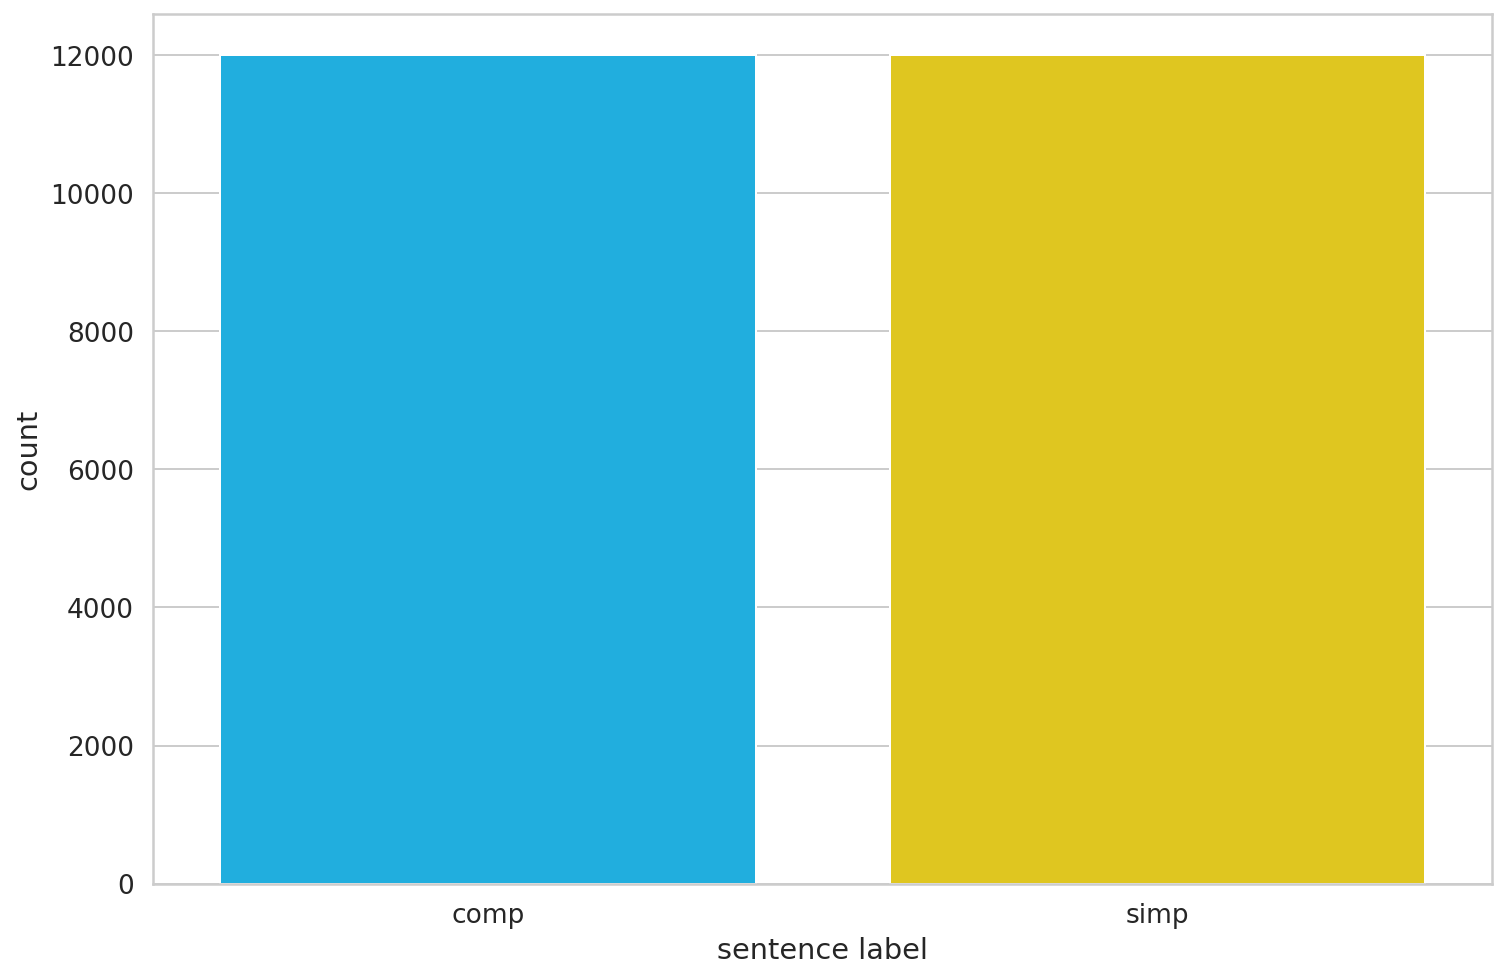

In [ ]:
ax = sns.countplot(x=labels)
plt.xlabel('sentence label')
ax.set_xticklabels(class_names);

In [ ]:
# PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
PRE_TRAINED_MODEL_NAME = 'roberta-base'

# tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'Ġwas', 'ĠI', 'Ġlast', 'Ġoutside', '?', 'ĠI', 'Ġam', 'Ġstuck', 'Ġat', 'Ġhome', 'Ġfor', 'Ġ2', 'Ġweeks', '.']
Token IDs: [1779, 21, 38, 94, 751, 116, 38, 524, 4889, 23, 184, 13, 132, 688, 4]


Get MAX_LEN based on distribution plot of sentence lengths:

In [ ]:
# token_lens = []

# for txt in sentences:
#   tokens = tokenizer.encode(txt, max_length=512)
#   token_lens.append(len(tokens))

# fig, ax = plt.subplots(figsize=(10,8))
# sns.histplot(token_lens, ax=ax)
# plt.xlim([0, 256]);
# plt.xlabel('Token count');

In [ ]:
MAX_LEN = 128

Create a PyTorch dataset:

In [ ]:
class SimplificationDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      truncation=True,
      padding='max_length',
      max_length=self.max_len,
      return_token_type_ids=False,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

Split the data:

In [ ]:
df = pd.DataFrame(zip(sentences, labels), columns=['sentence', 'label'])

df_train, df_test = train_test_split(df, test_size=2000, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)
print('train labels', np.mean(df_train['label']))
print('valid labels', np.mean(df_val['label']))
print('test  labels', np.mean(df_test['label']))

(22000, 2) (1000, 2) (1000, 2)
train labels 0.49986363636363634
valid labels 0.515
test  labels 0.488


We also need to create a couple of data loaders. Here's a helper function to do it:

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = SimplificationDataset(
    reviews=df['sentence'].to_numpy(),
    targets=df['label'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

data = next(iter(train_data_loader))
print(data['input_ids'].shape)
print(data['targets'].shape)

torch.Size([16, 128])
torch.Size([16])


## Text Classification with BERT and Hugging Face

Depending on the task you might want to use [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) or something else. 

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    # self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.bert = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    # self.fc1 = nn.Linear(self.bert.config.hidden_size, 128)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    # pooled_output = self.fc1(pooled_output)
    # pooled_output = F.relu(pooled_output)
    output = self.drop(pooled_output)
    return self.out(output)

We use a dropout layer for some regularization and a fully-connected layer for output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

Create an instance and move it to the GPU and add Softmax:

In [ ]:
# bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
bert_model = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
model = SentimentClassifier(len(class_names))
model = model.to(device)

input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

F.softmax(model(input_ids, attention_mask), dim=1)

# Training Setup

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [ ]:
EPOCHS = 6

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
len(train_data_loader)

1375

How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

Let's continue with writing a helper function for training our model for one epoch:

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

Let's write another one that helps us evaluate the model on a given data loader:

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Should freeze layers?





In [ ]:
# trainable_count = 2000

# layers_count = len([0 for p in model.parameters()])
# for i,param in enumerate(model.parameters()):
#   if i<(layers_count-trainable_count):
#     param.requires_grad = False
#   else:
#     param.requires_grad = True

# print('last', len([0 for p in model.parameters() if p.requires_grad==True]), 'layers are now trainable')

# (only once) Train the Model

Using those two, we can write our training loop. We'll also store the training history:

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state_{0}.bin'.format(dataset))
    best_accuracy = val_acc
    print('epoch', epoch+1, 'saved as best model so far\n')

Epoch 1/6
----------
Train loss 0.5665211769450794 accuracy 0.7170454545454545
Val   loss 0.5027651997312667 accuracy 0.791

epoch 1 saved as best model so far

Epoch 2/6
----------
Train loss 0.4670899245576425 accuracy 0.7935
Val   loss 0.4772221718042616 accuracy 0.79

Epoch 3/6
----------
Train loss 0.39336969510262665 accuracy 0.8366363636363636
Val   loss 0.5179468709088507 accuracy 0.795

epoch 3 saved as best model so far

Epoch 4/6
----------
Train loss 0.33353133985535666 accuracy 0.8695454545454545
Val   loss 0.5766417592290848 accuracy 0.788

Epoch 5/6
----------
Train loss 0.2925955782139843 accuracy 0.8945
Val   loss 0.7411952418467355 accuracy 0.776

Epoch 6/6
----------
Train loss 0.2612515318325975 accuracy 0.9126363636363636
Val   loss 0.7479937599883193 accuracy 0.775

CPU times: user 1h 13min 36s, sys: 25min 58s, total: 1h 39min 34s
Wall time: 1h 40min 4s


Note that we're storing the state of the best model, indicated by the highest validation accuracy.

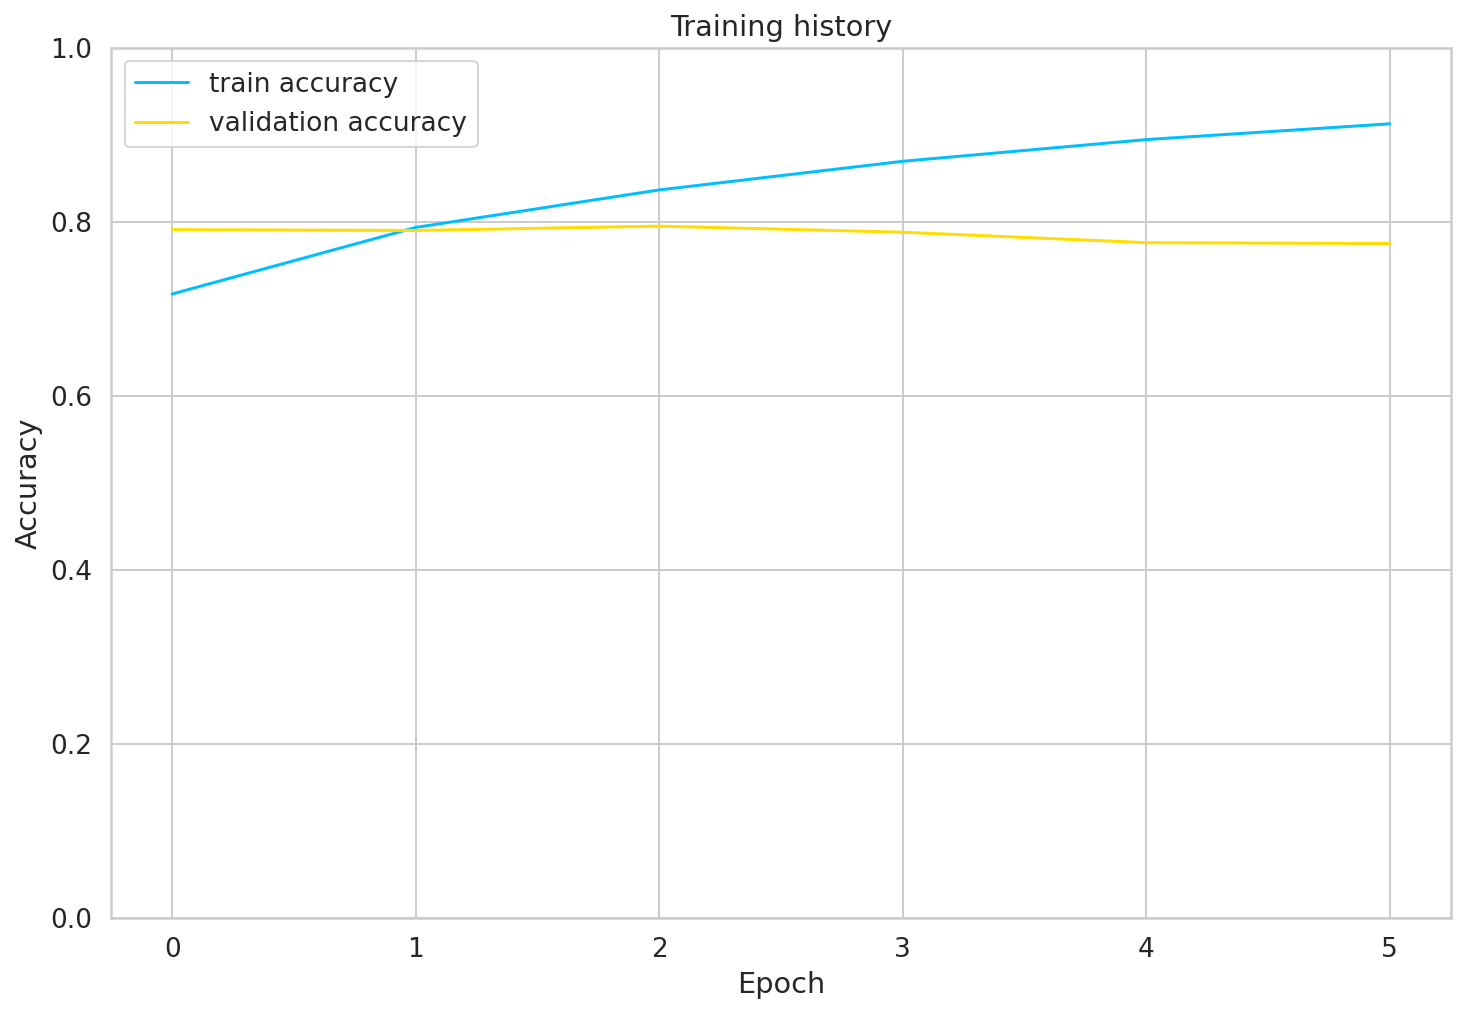

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
# reset notebook to clear GPU memory
exit()

# Load Best Model

In [ ]:
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state_{0}.bin'.format(dataset)))
model = model.to(device)

# Evaluation

So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8180000000000001

We'll define a helper function to get the predictions from our model:

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for i, d in enumerate(data_loader):

      clear_output()
      print(i+1, '/', len(data_loader))

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)
    
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text and the predicted probabilities (by applying the softmax on the model outputs):

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

print(classification_report(y_test, y_pred, target_names=class_names))

63 / 63
              precision    recall  f1-score   support

        comp       0.87      0.76      0.81       512
        simp       0.78      0.88      0.83       488

    accuracy                           0.82      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.82      0.82      0.82      1000



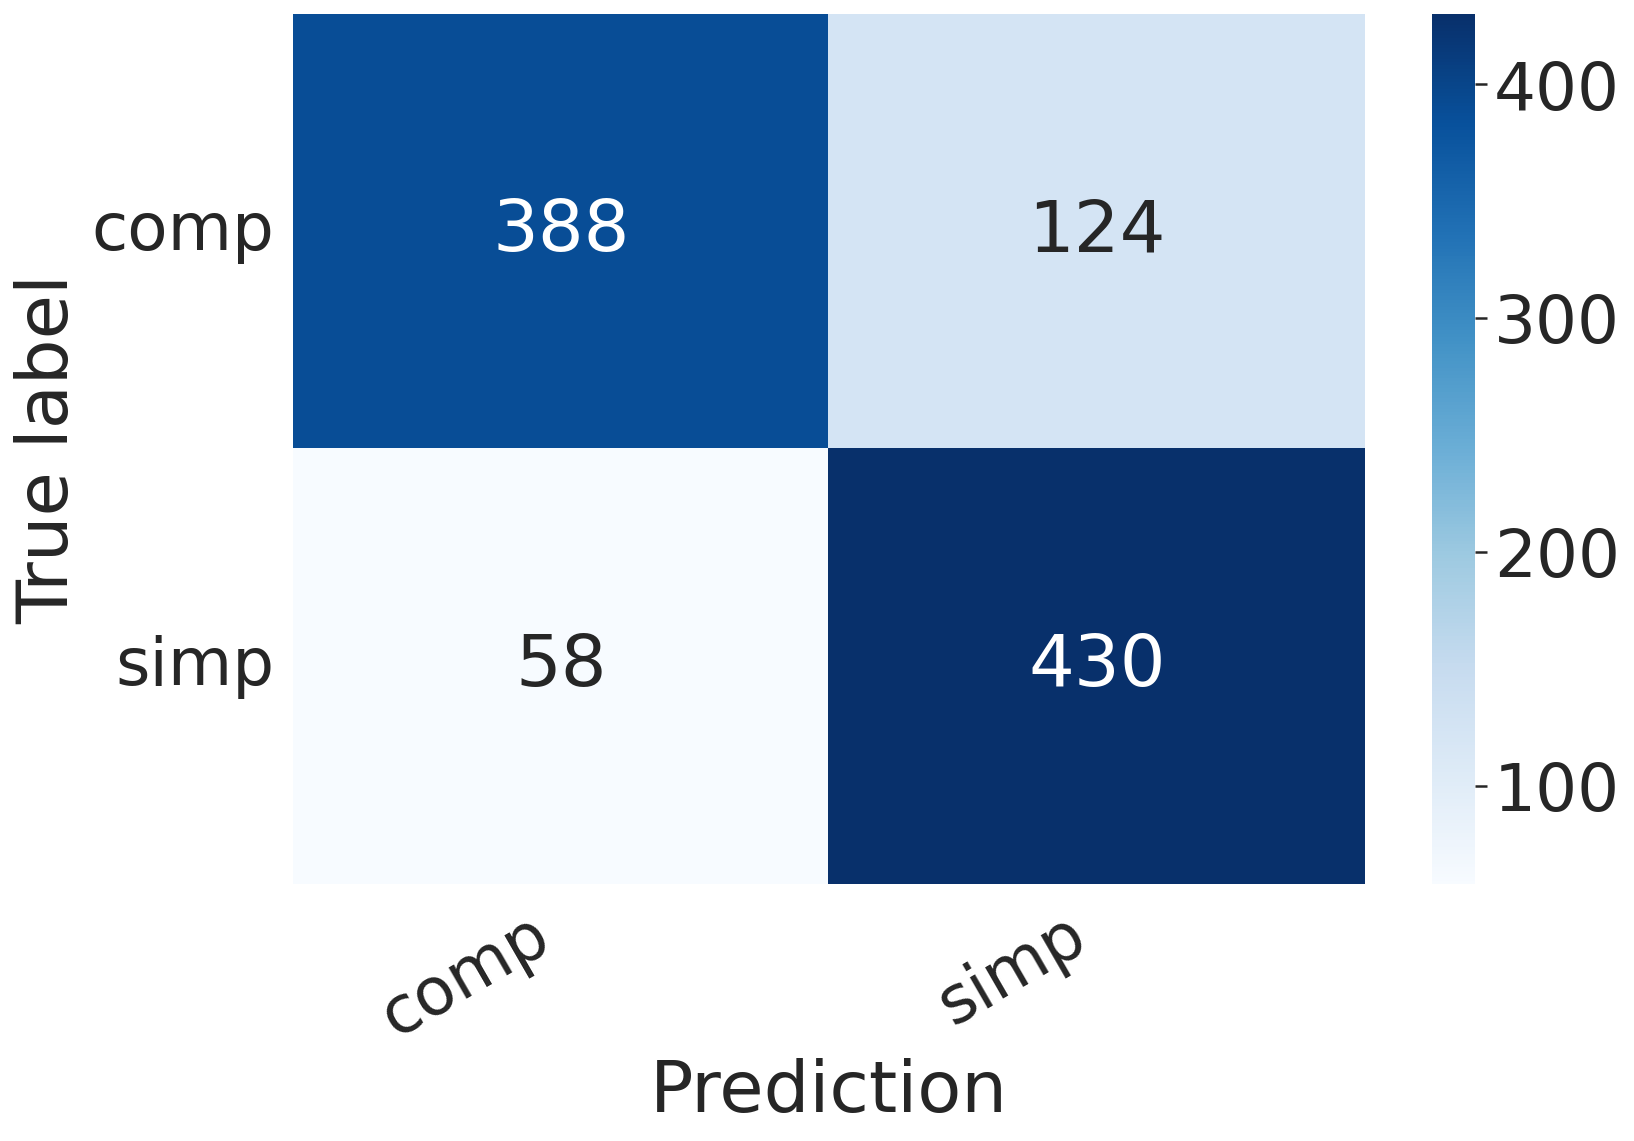

In [ ]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 36

def show_confusion_matrix(confusion_matrix):
  sns.set(font_scale=3)
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True label')
  plt.xlabel('Prediction');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

# Predicting on Raw Text

In [ ]:
# Read fine-tune data

prediction_text = []

with open('./wiki_comp_pred.txt', 'r', encoding='utf-8') as f:
  sents = f.read().splitlines()
  print(len(sents), 'comp sents loaded')
  print('example:', sents[0])
  print('============================================')
  prediction_text.extend(sents)

with open('./wiki_simp_pred.txt', 'r', encoding='utf-8') as f:
  sents = f.read().splitlines()
  print(len(sents), 'simp sents loaded')
  print('example:', sents[0])
  print('============================================')
  prediction_text.extend(sents)

print(len(prediction_text), 'fine-tune sentences')
sents = []

40000 comp sents loaded
example: The piano which features on the track partly emulates that of Lennon 's '' Jealous Guy '' , with the three octave jumps in C major .
40000 simp sents loaded
example: 1782 -- The first American commercial bank opens -LRB- Bank of North America -RRB- .
80000 fine-tune sentences


In [ ]:
df = pd.DataFrame(zip(prediction_text, np.zeros(len(prediction_text))), columns=['sentence', 'label'])
predict_data_loader = create_data_loader(df, tokenizer, MAX_LEN, 512)

prediction_text, results, results_probs, prediction_y = get_predictions(
  model,
  predict_data_loader
)

1 / 1


Save Predictions:

In [ ]:
classified_dict = {}

for clss in class_names:
  classified_dict[clss] = []

for idx,pred in enumerate(results):
  classified_dict[class_names[pred]].append(idx)

for clss,idxs in classified_dict.items():
  print(np.round(len(idxs)/len(prediction_text)*100, 2), '% classified as', clss, len(idxs))
  # exports text of this class
  with open('./roberta_predictions/{0}_trained/{0}_trained_pred_{1}.txt'.format(dataset,clss), 'w', encoding='utf-8') as f:
    f.writelines('\n'.join([prediction_text[idx] for idx in idxs]))
  # exports prediction_text indexes of this class
  with open('./roberta_predictions/{0}_trained/{0}_trained_pred_{1}_idxs.txt'.format(dataset,clss), 'w', encoding='utf-8') as f:
    f.writelines(','.join(np.array(idxs).astype(str)))

# exports all prediction_text
with open('./roberta_predictions/{0}_trained/{0}_trained_pred_all.txt'.format(dataset), 'w', encoding='utf-8') as f:
  f.writelines('\n'.join(prediction_text))

50.0 % classified as comp 1
50.0 % classified as simp 1


# Experiments (optional)

In [ ]:
class_names = ['comp', 'simp']
roberta_predictions = ['wiki_trained', 'news_trained', 'mixed_trained']
chunks = 8
thresholds = (np.arange(0, 100, 100/chunks) + (100/chunks)) / 100

all_fine = []

with open('./roberta_predictions/wiki_trained/wiki_trained_pred_all.txt', 'r', encoding='utf-8') as f:
  all_fine = f.read().splitlines()
  print(len(all_fine), 'sents loaded')

df = pd.DataFrame(zip(all_fine), columns=['sentence'])

80000 sents loaded


In [ ]:
for predict_name in roberta_predictions:
  all_classes = ['' for i in range(len(all_fine))]
  print('=========================')
  for clss in class_names:
    with open('./roberta_predictions/{0}/{0}_pred_{1}_idxs.txt'.format(predict_name,clss), 'r', encoding='utf-8') as f:
      idxs = np.array(f.read().split(',')).astype(int)
      print(predict_name, clss, 'prediction loaded', len(idxs))
      for idx in idxs:
        all_classes[idx] = clss

  if (np.sum([1 for clss in all_classes if clss=='']) > 0):
    print('!! some sentences were not classified !!')
  else:
    df[predict_name] = all_classes

wiki_trained comp prediction loaded 38414
wiki_trained simp prediction loaded 41586
news_trained comp prediction loaded 47118
news_trained simp prediction loaded 32882
mixed_trained comp prediction loaded 43208
mixed_trained simp prediction loaded 36792


In [ ]:
# if fine-tune data has labels

all_fine_y = np.full(len(all_fine), 'comp')
all_fine_y[:int(len(all_fine)/2)] = 'simp'
df['truth'] = all_fine_y
roberta_predictions.append('truth')

In [ ]:
df

,sentence,wiki_trained,news_trained,mixed_trained,truth
0,1782 -- The first American commercial bank ope...,simp,simp,simp,simp
1,This was the culmination of research in the 19...,comp,comp,comp,simp
2,Hitler said he first became an anti-Semite in ...,simp,simp,simp,simp
3,The most common use for the wok is stir frying...,simp,comp,comp,simp
4,The spin of an entity in quantum mechanics has...,simp,comp,simp,simp
...,...,...,...,...,...
79995,"The album sold 64,700 copies in its first week...",comp,comp,comp,comp
79996,Dornach is a municipality in the district of D...,comp,simp,comp,comp
79997,This color scheme generator helps a graphic de...,simp,comp,simp,comp
79998,1977 & ndash ; Rings of Uranus : Astronomers d...,comp,simp,comp,comp


In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

for pred in roberta_predictions:
  print(pred)
  print(classification_report(df['truth'], df[pred]))

wiki_trained
              precision    recall  f1-score   support

        comp       0.72      0.69      0.70     40000
        simp       0.70      0.73      0.71     40000

    accuracy                           0.71     80000
   macro avg       0.71      0.71      0.71     80000
weighted avg       0.71      0.71      0.71     80000

news_trained
              precision    recall  f1-score   support

        comp       0.62      0.73      0.67     40000
        simp       0.68      0.56      0.61     40000

    accuracy                           0.64     80000
   macro avg       0.65      0.64      0.64     80000
weighted avg       0.65      0.64      0.64     80000

mixed_trained
              precision    recall  f1-score   support

        comp       0.69      0.74      0.72     40000
        simp       0.72      0.66      0.69     40000

    accuracy                           0.70     80000
   macro avg       0.71      0.70      0.70     80000
weighted avg       0.71      0.70 

In [ ]:
for thres in thresholds:

  df = df.sample(frac=1).reset_index(drop=True)

  max_idx = thres * len(all_fine)
  print('#############', thres*100, '%', f'({max_idx})', '#############')

  temp_df = df[:int(max_idx)]
  for predict_name in roberta_predictions:
    print(predict_name)
    for clss in class_names:
      sents = list(temp_df[temp_df[predict_name] == clss]['sentence'])
      with open('./roberta_predictions/{0}/{0}_experiment/{0}_pred_{1}_{2}.txt'.format(predict_name,clss,thres), 'w', encoding='utf-8') as f: 
        f.writelines('\n'.join(sents))
      print(thres, f'({len(sents)})', clss, 'exported')
    
  with open('./roberta_predictions/all_experiment/all_pred_{0}.txt'.format(thres), 'w', encoding='utf-8') as f:
    f.writelines('\n'.join(list(temp_df['sentence'])))
  print('')
  print(thres, f'({len(temp_df)})', 'all exported')

############# 12.5 % (10000.0) #############
wiki_trained
0.125 (4691) comp exported
0.125 (5309) simp exported
news_trained
0.125 (5885) comp exported
0.125 (4115) simp exported
mixed_trained
0.125 (5347) comp exported
0.125 (4653) simp exported
label
0.125 (5013) comp exported
0.125 (4987) simp exported

0.125 (10000) all exported
############# 25.0 % (20000.0) #############
wiki_trained
0.25 (9631) comp exported
0.25 (10369) simp exported
news_trained
0.25 (11822) comp exported
0.25 (8178) simp exported
mixed_trained
0.25 (10773) comp exported
0.25 (9227) simp exported
label
0.25 (10029) comp exported
0.25 (9971) simp exported

0.25 (20000) all exported
############# 37.5 % (30000.0) #############
wiki_trained
0.375 (14481) comp exported
0.375 (15519) simp exported
news_trained
0.375 (17701) comp exported
0.375 (12299) simp exported
mixed_trained
0.375 (16251) comp exported
0.375 (13749) simp exported
label
0.375 (15080) comp exported
0.375 (14920) simp exported

0.375 (30000) all e